In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

# pd.set_option('display.max_columns', 200)

import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

import allensdk
import pkg_resources
print('allensdk version 2.10.2 or higher is required, you have {} installed'.format(pkg_resources.get_distribution("allensdk").version))
import mindscope_utilities.visual_behavior_ophys as ophys
import mindscope_utilities

allensdk version 2.10.2 or higher is required, you have 2.13.4 installed


In [2]:
# %matplotlib notebook
# %matplotlib inline
# %matplotlib qt 
%matplotlib widget

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip install allensdk

  Using cached Jinja2-2.11.3-py2.py3-none-any.whl (125 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.0.3
    Uninstalling Jinja2-3.0.3:
      Successfully uninstalled Jinja2-3.0.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.


In [6]:
my_cache_dir = Path("G:/allensdk")

bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=my_cache_dir)

cache = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=my_cache_dir)
          
experiment_table = bc.get_ophys_experiment_table()                          

In [5]:
# experiment_id = experiment_table.query('session_type == "OPHYS_1_images_A"').sample(random_state=10).index[0]
# experiment_id = experiment_table.query('session_type == "OPHYS_4_images_B" and project_code == "VisualBehavior"').sample(random_state=10).index[0]
# print('getting experiment data for experiment_id {}'.format(experiment_id))
# experiment_dataset = bc.get_behavior_ophys_experiment(experiment_id)
ophys_exp_id = 792815735
cell_id = 1086490790

import pickle
import shelve
with shelve.open('shelf-ophys', 'r', protocol=pickle.HIGHEST_PROTOCOL) as behavior_session_dict:
    experiment_dataset = behavior_session_dict[str(ophys_exp_id)]

In [55]:
# unique_stimuli = [stimulus for stimulus in experiment_dataset.stimulus_presentations['image_name'].unique() if stimulus != 'omitted']
unique_stimuli = experiment_dataset.stimulus_presentations['image_name'].unique()
colormap = {image_name: sns.color_palette().as_hex()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
# colormap['omitted'] = sns.color_palette().as_hex()[8] # assign gray to omitted
colormap

{'im061': '#1f77b4',
 'im062': '#ff7f0e',
 'im063': '#2ca02c',
 'im065': '#d62728',
 'im066': '#9467bd',
 'im069': '#8c564b',
 'im077': '#e377c2',
 'im085': '#7f7f7f',
 'omitted': '#bcbd22'}

In [7]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [8]:
sns.color_palette().as_hex()[8]

'#bcbd22'

In [56]:
experiment_dataset.stimulus_presentations['color'] = experiment_dataset.stimulus_presentations['image_name'].map(lambda image_name: colormap[image_name])
experiment_dataset.stimulus_presentations['color'].unique()

array(['#d62728', '#7f7f7f', '#bcbd22', '#2ca02c', '#1f77b4', '#ff7f0e',
       '#9467bd', '#8c564b', '#e377c2'], dtype=object)

In [10]:
def get_cell_timeseries_dict(dataset, cell_specimen_id):
    '''
    for a given cell_specimen ID, this function creates a dictionary with the following keys
    * timestamps: ophys timestamps
    * cell_roi_id
    * cell_specimen_id
    * dff
    This is useful for generating a tidy dataframe
    arguments:
        session object
        cell_specimen_id
    returns
        dict
    '''
    cell_dict = {
        'timestamps': dataset.ophys_timestamps,
        'cell_roi_id': [dataset.dff_traces.loc[cell_specimen_id]['cell_roi_id']] * len(dataset.ophys_timestamps),
        'cell_specimen_id': [cell_specimen_id] * len(dataset.ophys_timestamps),
        'dff': dataset.dff_traces.loc[cell_specimen_id]['dff'],

    }
    return cell_dict

experiment_dataset.tidy_dff_traces = pd.concat(
    [pd.DataFrame(get_cell_timeseries_dict(experiment_dataset, cell_specimen_id)) for cell_specimen_id in experiment_dataset.dff_traces.reset_index()['cell_specimen_id']]
).reset_index(drop=True)

experiment_dataset.tidy_dff_traces.sample(5)

,timestamps,cell_roi_id,cell_specimen_id,dff
61435,1988.10930,1080900658,1086490397,-0.010723
2693899,970.38819,1080900859,1086491195,0.053183
2554966,1011.59616,1080900851,1086491165,0.035659
977491,4406.13718,1080900728,1086490680,-0.071216
1740852,1888.59074,1080900794,1086490937,0.038311


# Matplotlib

In [11]:
cell_id = 1086490790

In [12]:
def plot_stimuli(trial, ax):
    '''
    plot stimuli as colored bars on specified axis
    '''
    stimuli = experiment_dataset.stimulus_presentations.query('stop_time >= {} and start_time <= {} and not omitted'.format(float(trial['start_time']), float(trial['stop_time'])))
    for idx, stimulus in stimuli.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=stimulus['color'], alpha=0.5)

        
def plot_running(trial, ax):
    '''
    plot running speed for trial on specified axes
    '''
    trial_running_speed = experiment_dataset.running_speed.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    ax.plot(
        trial_running_speed['timestamps'],
        trial_running_speed['speed'],
        color='black'
    )
    ax.set_title('running speed')
    ax.set_ylabel('speed (cm/s)')
    

def plot_licks(trial, ax):
    '''
    plot licks as black dots on specified axis
    '''
    trial_licks = experiment_dataset.licks.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    ax.plot(
        trial_licks['timestamps'],
        np.zeros_like(trial_licks['timestamps']),
        marker = 'o',
        linestyle = 'none',
        color='black'
    )
    

def plot_rewards(trial, ax):
    '''
    plot rewards as blue diamonds on specified axis
    '''
    trial_rewards = experiment_dataset.rewards.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    ax.plot(
        trial_rewards['timestamps'],
        np.zeros_like(trial_rewards['timestamps']),
        marker = 'd',
        linestyle = 'none',
        color='blue',
        markersize = 10,
        alpha = 0.25
    )
    
def plot_pupil(trial, ax):
    '''
    plot pupil area on specified axis
    '''
    trial_eye_tracking = experiment_dataset.eye_tracking.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    ax.plot(
        trial_eye_tracking['timestamps'],
        trial_eye_tracking['pupil_area'],
        color='black'
    )
    ax.set_title('pupil area')
    ax.set_ylabel('pupil area\n$(pixels^2)$')
    

def plot_dff(trial, ax):
    '''
    plot each cell's dff response for a given trial
    '''
    trial_dff_traces = experiment_dataset.tidy_dff_traces.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    for cell_specimen_id in experiment_dataset.tidy_dff_traces['cell_specimen_id'].unique():
        ax.plot(
            trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'],
            trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff']
        )
        ax.set_title('deltaF/F responses')
        ax.set_ylabel('dF/F')
        
        
def plot_dff_cell(cell_specimen_id, trial, ax):
    '''
    plot each cell's dff response for a given trial
    '''
    trial_dff_traces = experiment_dataset.tidy_dff_traces.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    ax.plot(
            trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'],
            trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff'])
    ax.set_title('deltaF/F responses')
    ax.set_ylabel('dF/F')
        
    
def make_trial_plot(trial):
    '''
    combine all plots for a given trial
    '''
    fig, axes = plt.subplots(4, 1, figsize = (15, 8), sharex=True)

    for ax in axes:
        plot_stimuli(trial, ax)
            
    plot_running(trial, axes[0])

    plot_licks(trial, axes[1])
    plot_rewards(trial, axes[1])
    
    axes[1].set_title('licks and rewards')
    axes[1].set_yticks([])
    axes[1].legend(['licks','rewards'])

    plot_pupil(trial, axes[2])

    # plot_dff(trial, axes[3])
    plot_dff_cell(cell_id,trial, axes[3])
    axes[3].set_xlabel('time in session (seconds)')
    fig.tight_layout()
    # return fig, axes
    return

In [13]:

# trial.start_time = experiment_dataset.trials.iloc[0].start_time
# trial.stop_time = experiment_dataset.trials.iloc[-1].stop_time


trial.start_time = experiment_dataset.trials.iloc[0].start_time
trial.stop_time = experiment_dataset.trials.iloc[10].stop_time

# fig, axes = make_trial_plot(trial)
make_trial_plot(trial)

# print(experiment_dataset.trials)
experiment_dataset.trials.iloc[0].start_time
experiment_dataset.trials.iloc[-1].stop_time

NameError: name 'trial' is not defined

# using plotly

In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [166]:
def plot_stimuli(trial, fig):
    '''
    plot stimuli as colored bars on specified axis
    '''
    # stimuli = experiment_dataset.stimulus_presentations.query('stop_time >= {} and start_time <= {} and not omitted'
    #                                                           .format(float(trial['start_time']), float(trial['stop_time'])))
    stimuli = experiment_dataset.stimulus_presentations.query('stop_time >= {} and start_time <= {}'
                                                          .format(float(trial['start_time']), float(trial['stop_time'])))
    for idx, stimulus in stimuli.iterrows():
#         ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=stimulus['color'], alpha=0.5)
        fig.add_vrect(x0=stimulus['start_time'], x1=stimulus['stop_time'], row="all", col=1,
              fillcolor=stimulus['color'], opacity=0.3, line_width=1, exclude_empty_subplots=False,layer="below")
#         fig.add_vrect(x0=stimulus['start_time'], x1=stimulus['stop_time'], row="all", col="all", fillcolor='yellow', opacity=0.8, line_width=0)
        
        
def plot_running(trial, fig):
    '''
    plot running speed for trial on specified axes
    '''
    trial_running_speed = experiment_dataset.running_speed.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))

    fig.add_trace(go.Scattergl(x=trial_running_speed['timestamps'], 
                             y=trial_running_speed['speed'],
                             line=dict(color="black"), name='running speed'),
              row=1, col=1)

    

def plot_licks(trial, fig):
    '''
    plot licks as black dots on specified axis
    '''
    trial_licks = experiment_dataset.licks.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    fig.add_trace(go.Scattergl(x=trial_licks['timestamps'], y=np.zeros_like(trial_licks['timestamps']),mode='markers',marker=dict(
            color='black',
            size=10,
        ), name='licks'),
              row=2, col=1)
    
    

def plot_rewards(trial, fig):
    '''
    plot rewards as blue diamonds on specified axis
    '''
    trial_rewards = experiment_dataset.rewards.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), float(trial['stop_time'])))
    fig.add_trace(go.Scattergl(x=trial_rewards['timestamps'], y=np.zeros_like(trial_rewards['timestamps']),mode='markers',marker=dict(
            color='blue',
            symbol="diamond",
            size=12,
        ), name='rewards'),
              row=2, col=1)           
                  
    
def plot_pupil(trial, fig):
    '''
    plot pupil area on specified axis
    '''
    trial_eye_tracking = experiment_dataset.eye_tracking.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), 
                                                                                                               float(trial['stop_time'])))
    fig.add_trace(go.Scattergl(x=trial_eye_tracking['timestamps'], 
                             y=trial_eye_tracking['pupil_area'],
                             line=dict(color="black"), name='pupil area'),
              row=3, col=1)
    

def plot_dff(trial, fig):
    '''
    plot each cell's dff response for a given trial
    '''
    trial_dff_traces = experiment_dataset.tidy_dff_traces.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), 
                                                                                                                float(trial['stop_time'])))
    for cell_specimen_id in experiment_dataset.tidy_dff_traces['cell_specimen_id'].unique():
        fig.add_trace(go.Scattergl(x=trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'], 
                             y=trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff'],name=str(cell_specimen_id),
                                    line_shape='linear'
                                  ),
              row=4, col=1)    

        
def plot_downsample_dff(tidy_dff, trial, fig):
    '''
    plot each cell's dff response for a given trial
    '''
    trial_dff_traces = tidy_dff.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), 
                                                                                                                float(trial['stop_time'])))
    for cell_specimen_id in tidy_dff['cell_specimen_id'].unique():
        fig.add_trace(go.Scattergl(x=trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'], 
                             y=trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff'],name=str(cell_specimen_id),
                                    line_shape='linear', visible = "legendonly"
                                  ),
              row=4, col=1)    

        
        
def plot_dff_cell(cell_specimen_id, trial, fig):
    '''
    plot each cell's dff response for a given trial
    '''
    trial_dff_traces = experiment_dataset.tidy_dff_traces.query('timestamps >= {} and timestamps <= {} '.format(float(trial['start_time']), 
                                                                                                                float(trial['stop_time'])))
    fig.add_trace(go.Scattergl(x=trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'], 
                             y=trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff'], name='dff'
                  ),row=4, col=1)
    
    
def make_trial_plot_plotly(trial, tidy_downsample_dff = None):
    '''
    combine all plots for a given trial
    '''
    fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
#                     vertical_spacing=0.02,
                        vertical_spacing = 0
                   # subplot_titles=("running speed","licks and rewards", "pupil area", "deltaF/F responses")
                       )

    # Update yaxis properties
    fig.update_yaxes(title_text="speed (cm/s)",row=1, col=1)
    fig.update_yaxes(title_text='pupil area\n (pixels^2)', row=3, col=1)
    fig.update_yaxes(title_text="dF/F", row=4, col=1)
    fig.update_xaxes(title_text="time in session (seconds)",row=4, col=1)
    
    fig.update_yaxes(showticklabels=False, row=2, col=1)
    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=False, zeroline=False)
    # fig.update_xaxes(dtick=0.5)
    
    
    plot_stimuli(trial, fig)
    plot_running(trial, fig)
    plot_licks(trial, fig)
    plot_rewards(trial, fig)
    plot_pupil(trial, fig)

    plot_downsample_dff(tidy_downsample_dff, trial, fig)
    # plot_dff(trial, fig)
    # plot_dff_cell(cell_id,trial, fig)
    
   
        
    fig.update_layout(height=800, width=1000,
                      title_text="plot")
    fig.update_layout(showlegend=True)
    fig.update_layout(plot_bgcolor = "white")
    # 'rgb(233,233,233)'
    
    fig.write_html("file.html")
    fig.show()

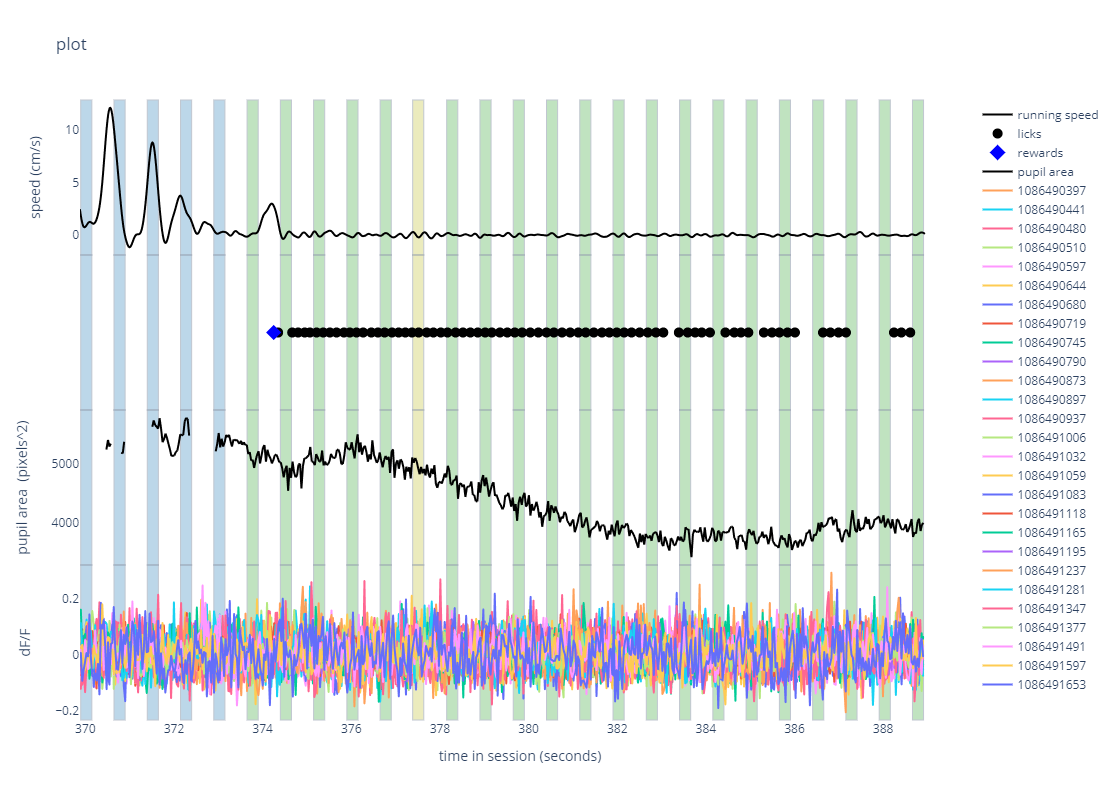

In [134]:
trial = experiment_dataset.trials.iloc[4].copy()
trial.start_time = experiment_dataset.trials.iloc[9].start_time
trial.stop_time = experiment_dataset.trials.iloc[15].stop_time

# fig, axes = make_trial_plot(trial)
make_trial_plot_plotly(trial)

# print(experiment_dataset.trials)
# experiment_dataset.trials.iloc[0].start_time
# experiment_dataset.trials.iloc[-1].stop_time

In [170]:
downsampled_dff = downsample(experiment_dataset.tidy_dff_traces, sampling_frequency = 10)

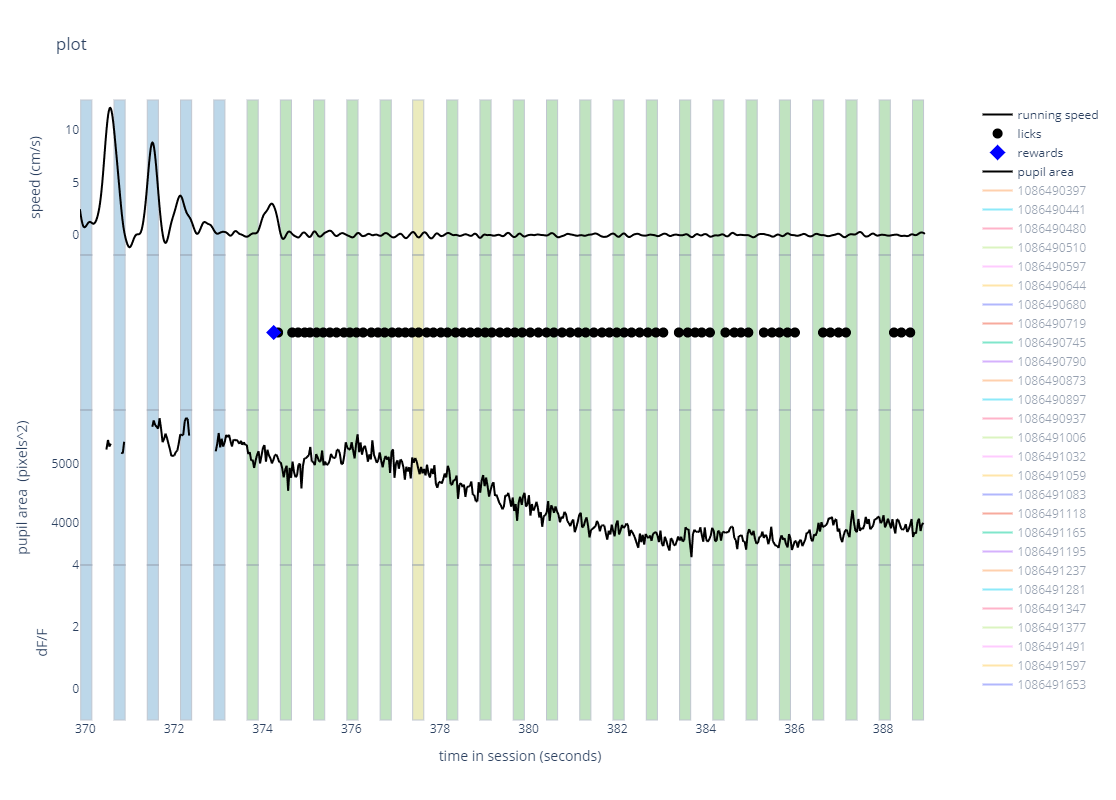

In [171]:
trial = experiment_dataset.trials.iloc[4].copy()
trial.start_time = experiment_dataset.trials.iloc[9].start_time
trial.stop_time = experiment_dataset.trials.iloc[15].stop_time

# fig, axes = make_trial_plot(trial)
make_trial_plot_plotly(trial,downsampled_dff)

# print(experiment_dataset.trials)
# experiment_dataset.trials.iloc[0].start_time
# experiment_dataset.trials.iloc[-1].stop_time

In [136]:
experiment_dataset.tidy_dff_traces

,timestamps,cell_roi_id,cell_specimen_id,dff
0,2.55274,1080900658,1086490397,0.215474
1,2.58505,1080900658,1086490397,0.281105
2,2.61736,1080900658,1086490397,0.277351
3,2.64967,1080900658,1086490397,0.403304
4,2.68198,1080900658,1086490397,0.342359
...,...,...,...,...
3785611,4534.14087,1080900984,1086491653,0.106516
3785612,4534.17319,1080900984,1086491653,0.036919
3785613,4534.20552,1080900984,1086491653,0.222780
3785614,4534.23784,1080900984,1086491653,0.031466


In [145]:
# experiment_dataset.dff_traces

In [156]:
from scipy.interpolate import interp1d
def downsample(df, sampling_frequency):
    downsample_pd = pd.DataFrame()
    for cell_specimen_id in df['cell_specimen_id'].unique():
        cell_df = df[df.cell_specimen_id == cell_specimen_id]
        sample_times = np.arange(cell_df['timestamps'].min(), cell_df['timestamps'].max(), 1/sampling_frequency)
        f = interp1d(cell_df['timestamps'], cell_df['dff'])
        tmp = pd.DataFrame({'timestamps': sample_times, 'dff': f(sample_times), 'cell_roi_id': cell_df.cell_roi_id.iloc[0],
                         'cell_specimen_id': cell_df.cell_specimen_id.iloc[0]})
        downsample_pd = pd.concat([downsample_pd,tmp])
    return downsample_pd

In [157]:
df = experiment_dataset.tidy_dff_traces.copy()
# df = experiment_dataset.tidy_dff_traces[experiment_dataset.tidy_dff_traces.cell_specimen_id == 1086490397].copy()
df

,timestamps,cell_roi_id,cell_specimen_id,dff
0,2.55274,1080900658,1086490397,0.215474
1,2.58505,1080900658,1086490397,0.281105
2,2.61736,1080900658,1086490397,0.277351
3,2.64967,1080900658,1086490397,0.403304
4,2.68198,1080900658,1086490397,0.342359
...,...,...,...,...
3785611,4534.14087,1080900984,1086491653,0.106516
3785612,4534.17319,1080900984,1086491653,0.036919
3785613,4534.20552,1080900984,1086491653,0.222780
3785614,4534.23784,1080900984,1086491653,0.031466


In [158]:
tmp = downsample(df, sampling_frequency = 11)
tmp

,timestamps,dff,cell_roi_id,cell_specimen_id
0,2.552740,0.215474,1080900658,1086490397
1,2.643649,0.379833,1080900658,1086490397
2,2.734558,0.208335,1080900658,1086490397
3,2.825467,0.368547,1080900658,1086490397
4,2.916376,0.303876,1080900658,1086490397
...,...,...,...,...
49844,4533.825467,0.138167,1080900984,1086491653
49845,4533.916376,0.271711,1080900984,1086491653
49846,4534.007285,0.153260,1080900984,1086491653
49847,4534.098195,0.081699,1080900984,1086491653


In [179]:
experiment_dataset.stimulus_presentations['start_time']

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set,color
stimulus_presentations_id,,,,,,,,,,,
0,306.84438,307.09462,0.25024,im065,0,False,False,17985,18000.0,Natural_Images_Lum_Matched_set_training_2017.0...,#d62728
1,307.59503,307.84524,0.25021,im065,0,False,False,18030,18045.0,Natural_Images_Lum_Matched_set_training_2017.0...,#d62728
2,308.34564,308.59587,0.25023,im065,0,False,False,18075,18090.0,Natural_Images_Lum_Matched_set_training_2017.0...,#d62728
3,309.09622,309.34650,0.25028,im065,0,False,False,18120,18135.0,Natural_Images_Lum_Matched_set_training_2017.0...,#d62728
4,309.84689,310.09707,0.25018,im065,0,False,False,18165,18180.0,Natural_Images_Lum_Matched_set_training_2017.0...,#d62728
...,...,...,...,...,...,...,...,...,...,...,...
4801,3911.05171,3911.30197,0.25026,im063,4,False,False,234046,234061.0,Natural_Images_Lum_Matched_set_training_2017.0...,#2ca02c
4802,3911.80231,3912.05259,0.25028,im063,4,False,False,234091,234106.0,Natural_Images_Lum_Matched_set_training_2017.0...,#2ca02c
4803,3912.55300,3912.80322,0.25022,im063,4,False,False,234136,234151.0,Natural_Images_Lum_Matched_set_training_2017.0...,#2ca02c


In [184]:
stimulus_response_xr = ophys.get_stimulus_response_xr(experiment_dataset)
# etr = mindscope_utilities.event_triggered_response(
#     data = df, # the data you wish to operate on
#     t = 'timestamps', # the desired time values
#     y = 'dff', # the desired y values
#     event_times = experiment_dataset.stimulus_presentations['start_time'], # the list or array of events
#     t_start = 0, # desired time before each event of interest
#     t_end = 0.5, # desired time after each event of interest,
#     output_sampling_rate = 30, # the sampling rate on which to interpolate. 
#     interpolate=True
# )

100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


In [186]:
print(stimulus_response_xr)

<xarray.Dataset>
Dimensions:                    (eventlocked_timestamps: 186, stimulus_presentations_id: 4806, cell_specimen_id: 27)
Coordinates:
  * eventlocked_timestamps     (eventlocked_timestamps) float64 -3.0 ... 2.979
  * stimulus_presentations_id  (stimulus_presentations_id) int64 0 1 ... 4805
  * cell_specimen_id           (cell_specimen_id) int64 1086490397 ... 108649...
Data variables:
    eventlocked_traces         (cell_specimen_id, stimulus_presentations_id, eventlocked_timestamps) float64 ...
    mean_response              (cell_specimen_id, stimulus_presentations_id) float64 ...
    mean_baseline              (cell_specimen_id, stimulus_presentations_id) float64 ...


In [32]:
experiment_dataset.trials

,start_time,stop_time,lick_times,reward_time,reward_volume,hit,false_alarm,miss,stimulus_change,aborted,...,catch,auto_rewarded,correct_reject,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name
trials_id,,,,,,,,,,,,,,,,,,,,,
0,306.82774,314.85097,[],NaN,0.000,False,False,True,True,False,...,False,False,False,8.02323,NaN,18209.0,310.601956,inf,im065,im085
1,315.08449,319.98848,"[319.50476, 319.67151]",NaN,0.000,False,False,False,False,True,...,False,False,False,4.90399,NaN,NaN,NaN,NaN,im085,im085
2,320.33877,329.86319,[],NaN,0.000,False,False,True,True,False,...,False,False,False,9.52442,NaN,19109.0,325.614306,inf,im085,im065
3,330.09670,342.62361,[338.52026],338.52026,0.007,True,False,False,True,False,...,False,False,False,12.52691,338.52026,19874.0,338.374716,0.145544,im065,im063
4,342.85716,354.63339,"[351.26397, 351.73102, 351.88123, 352.01464, 3...",NaN,0.000,False,False,True,True,False,...,False,False,False,11.77623,351.26397,20594.0,350.384416,0.879554,im063,im061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,3868.25012,3879.27578,[],NaN,0.000,False,False,True,True,False,...,False,False,False,11.02566,NaN,231885.0,3875.026806,inf,im063,im085
933,3879.50930,3889.03380,[],NaN,0.000,False,False,True,True,False,...,False,False,False,9.52450,NaN,232470.0,3884.784776,inf,im085,im077
934,3889.26727,3896.53991,[],NaN,0.000,False,False,False,False,False,...,True,False,True,7.27264,NaN,232920.0,3892.290916,inf,im077,im077


In [66]:
stimuli = experiment_dataset.stimulus_presentations.query('stop_time >= {} and start_time <= {} and not omitted'.format(float(trial['start_time']), float(trial['stop_time'])))
stimuli.head()

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set,color
stimulus_presentations_id,,,,,,,,,,,
84,369.89583,370.14603,0.25020,im061,3,False,False,21765,21780.0,Natural_Images_Lum_Matched_set_training_2017.0...,#1f77b4
85,370.64645,370.89665,0.25020,im061,3,False,False,21810,21825.0,Natural_Images_Lum_Matched_set_training_2017.0...,#1f77b4
86,371.39706,371.64736,0.25030,im061,3,False,False,21855,21870.0,Natural_Images_Lum_Matched_set_training_2017.0...,#1f77b4
87,372.14774,372.39787,0.25013,im061,3,False,False,21900,21915.0,Natural_Images_Lum_Matched_set_training_2017.0...,#1f77b4
88,372.89837,373.14851,0.25014,im061,3,False,False,21945,21960.0,Natural_Images_Lum_Matched_set_training_2017.0...,#1f77b4


In [69]:
experiment_dataset.trials.iloc[100]

start_time              656.62975
stop_time               659.66555
lick_times            [659.34863]
reward_time                   NaN
reward_volume                 0.0
hit                         False
false_alarm                 False
miss                        False
stimulus_change             False
aborted                      True
go                          False
catch                       False
auto_rewarded               False
correct_reject              False
trial_length               3.0358
response_time                 NaN
change_frame                  NaN
change_time                   NaN
response_latency              NaN
initial_image_name          im065
change_image_name           im065
Name: 100, dtype: object